In [1]:
%matplotlib inline
import pandas as pd
import datetime

In [2]:
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')


In [3]:
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM','INTEL',
               'INTIFA2', 'INTNSL']
df.head()


,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,...,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM,INTEL,INTIFA2,INTNSL
0,FUELHH,20200101,1,7912,0,670,6953,5004,0,672,...,130,1704,0,854,0,2353,854,0,0,0
1,FUELHH,20200101,2,8420,0,670,6949,5043,0,669,...,123,1704,0,852,0,2358,854,0,0,0
2,FUELHH,20200101,3,8037,0,670,6952,5030,0,662,...,122,1704,0,852,0,2356,854,0,0,0
3,FUELHH,20200101,4,7499,0,670,6948,4825,0,591,...,122,1704,0,852,0,2343,854,0,0,0
4,FUELHH,20200101,5,7020,0,669,6954,4689,0,548,...,121,1704,0,852,0,2356,854,0,0,0


In [4]:
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), axis = 1)


<AxesSubplot:xlabel='datetime'>

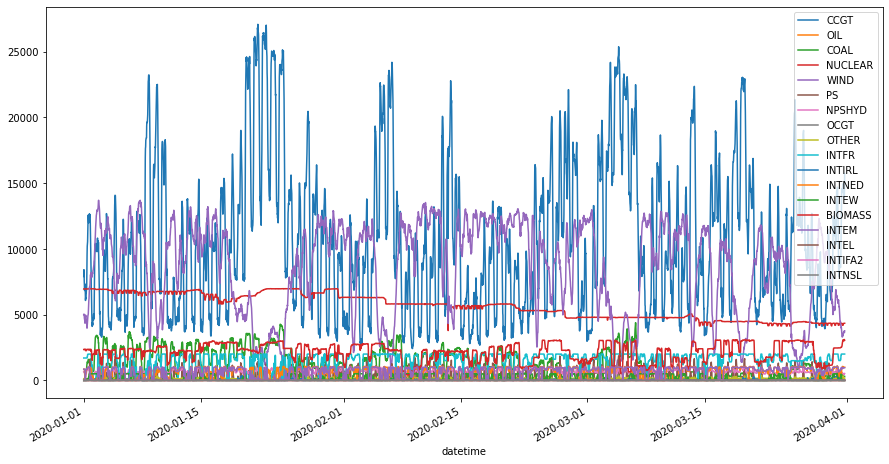

In [5]:
df.drop(
    ['HDF', 'date', 'half_hour_increment'], axis = 1
    ).set_index('datetime').plot(figsize=(15,8))


In [6]:
!pip install "cython==0.29.30"
!pip install 'pystan==3.5.0' convertdate plotly papermill requests dash
!pip install "prophet"


     |████████████████████████████████| 2.0 MB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.2 MB/s  eta 0:00:01
     |████████████████████████████████| 9.8 MB 94.9 MB/s eta 0:00:01
     |████████████████████████████████| 43.7 MB 97.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 95.7 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 13.6 MB/s  eta 0:00:01
     |████████████████████████████████| 5.4 MB 105.3 MB/s eta 0:00:01
     |████████████████████████████████| 661 kB 92.0 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 12.6 MB/s eta 0:00:01


  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730971 sha256=5b9f02b74c8bded7fce984380fa23c0be19727142d65e7c04596bb83d5478703
  Stored in directory: /home/ubuntu/.cache/pip/wheels/33/3d/82/4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus
     |████████████████████████████████| 8.9 MB 26.0 MB/s eta 0:00:01
     |████████████████████████████████| 179 kB 106.7 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 1.8 MB 111.7 MB/s eta 0:00:01


In [7]:
df_for_prophet = df[['datetime', 'CCGT']].rename(columns = {'datetime':'ds', 'CCGT':'y'})


In [8]:
X = df_for_prophet.copy()
y = df_for_prophet['y']
proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))
X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]


In [9]:
from prophet import Prophet
m = Prophet()
m.fit(X_train)


14:39:45 - cmdstanpy - INFO - Chain [1] start processing
14:39:45 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #uncomment to inspect the DataFrame


<Figure size 432x288 with 0 Axes>

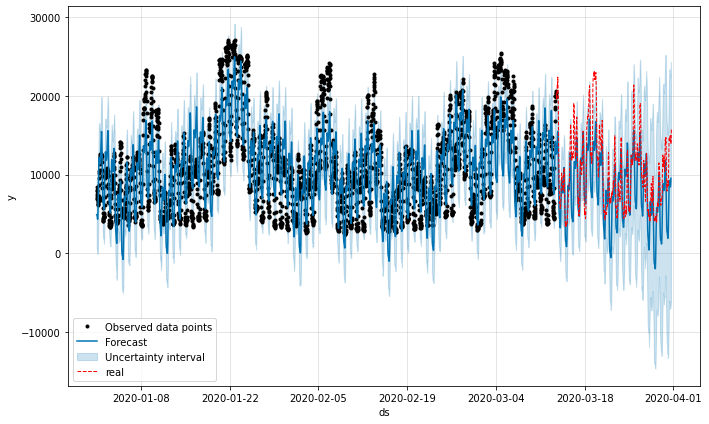

In [11]:
import matplotlib.pyplot as plt
plt.gcf()
fig = m.plot(forecast)
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real')
plt.legend()


In [12]:
import pickle
# m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)
